In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from numba import jit, njit, vectorize
import time

## Defining functions that we need:

In [121]:
#Trial energy 1
def TrialEnergy1(alpha,omega,r1,r2):
    return 0.5*omega**2*(r1**2 + r2**2)*(1 - alpha**2) + 3*omega*alpha

@vectorize#By far the quickest of the three for vectors
def TrialEnergy1Vec(alpha,omega,r1,r2):
    #r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    #r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    return 0.5*omega**2*(r1**2 + r2**2)*(1 - alpha**2) + 3*omega*alpha

@jit(nopython=True)
def TrialEnergyJIT(alpha,omega,r1,r2):
    return 0.5*(omega**2)*(r1**2 + r2**2)*(1 - alpha**2) + 3*omega*alpha

#Athuga betur hvernig ég á að díla við að deila með núlli þegar Coulomb víxlverkun til staðar
@jit(nopython=True)
def TrialEnergyJITwithCoulomb(alpha,omega,x1,y1,z1,x2,y2,z2):
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    r_12 = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
    if abs(r_12) <= 1e-8:
        return 0
    else:
        return 0.5*(omega**2)*(r1**2 + r2**2)*(1 - alpha**2) + 3*omega*alpha + 1/r_12
    
#Trial energy for the seconds trial wave function
@jit(nopython=True)
def TrialEnergy2JIT(alpha,beta,omega,x1,y1,z1,x2,y2,z2):
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    r_12 = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
    TrialEnergy1 = TrialEnergyJITwithCoulomb(alpha,omega,x1,y1,z1,x2,y2,z2)
    if abs(r_12) <= 1e-8:
        return 0
    else:
        TrialEnergy2Partial = (1/(2*(1+beta*r_12)**2))*(alpha*omega*r_12 - (1/2*(1+beta*r_12)**2) - 2/r_12 + (2*beta/(1+beta*r_12)))
        return TrialEnergy1 + TrialEnergy2Partial
    

@jit
def TrialWaveFunction1(alpha,omega,x1,y1,z1,x2,y2,z2):
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    return np.exp(-alpha*omega*(r1**2 + r2**2)/2)

@jit
def TrialWaveFunction2(alpha,beta,omega,x1,y1,z1,x2,y2,z2):
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    r_12 = np.sqrt((x1-x2)**2 - (y1-y2)**2 - (z1-z2)**2)
    return np.exp(-alpha*omega*(r1**2 + r2**2)/2)*np.exp(r_12/(2*(1 + beta*r_12)))

In [126]:
alpha = 1
beta = 2
trialEnergyTemp = TrialEnergyJIT(alpha,1,0,0)
print(trialEnergyTemp)
trialEnergyTemp = TrialEnergyJITwithCoulomb(alpha,1,1e-7,0,0,0,0,0)
print(trialEnergyTemp)
x1 = np.random.exponential()
y1 = np.random.exponential()
z1 = np.random.exponential()
x2 = np.random.exponential()
y2 = np.random.exponential()
z2 = np.random.exponential()
trialEnergyTemp = TrialEnergyJITwithCoulomb(alpha,1,x1,y1,z1,z2,y2,z2)
print(trialEnergyTemp)
trialEnergyTemp1 = TrialEnergy2JIT(alpha,beta,1,x1,y1,z1,z2,y2,z2)
print(trialEnergyTemp1)

3.0
10000003.0
3.907341807245056
3.683433853170855


## Monte Carlo and Metropolis algo:

In [132]:
#Probability ratio
@jit
def ProbRatio(Rold,Rnew,alpha,omega):#Rold and Rnew as an array
    new = TrialWaveFunction2(alpha,beta,omega,Rnew[0],Rnew[1],Rnew[2],Rnew[3],Rnew[4],Rnew[5])
    new = new**2
    old = TrialWaveFunction2(alpha,beta,omega,Rold[0],Rold[1],Rold[2],Rold[3],Rold[4],Rold[5])
    old = old**2
    return new/old

#Probability ratio for the second trial wave function
@jit
def ProbRatio2(Rold,Rnew,alpha,beta,omega):#Rold and Rnew as an array
    new = TrialWaveFunction1(alpha,omega,Rnew[0],Rnew[1],Rnew[2],Rnew[3],Rnew[4],Rnew[5])
    new = new**2
    old = TrialWaveFunction1(alpha,omega,Rold[0],Rold[1],Rold[2],Rold[3],Rold[4],Rold[5])
    old = old**2
    return new/old

#Metropolis part for the first trial wave function
@jit
def Metropolis(Rold,Rnew,alpha,omega):
    Acceptance = False
    probRatio = ProbRatio(Rold,Rnew,alpha,omega)
    if probRatio > 1:
        Acceptance = True
    elif np.random.random() <= probRatio:
        Acceptance = True
    else:
        Acceptance = False
    return Acceptance

#Metropolis test for the second trial wave function
@jit
def Metropolis2(Rold,Rnew,alpha,beta,omega):
    Acceptance = False
    probRatio = ProbRatio2(Rold,Rnew,alpha,beta,omega)
    if probRatio > 1:
        Acceptance = True
    elif np.random.random() <= probRatio:
        Acceptance = True
    else:
        Acceptance = False
    return Acceptance

In [7]:
R1 = np.array([1,1,1,1,1,1])
R2 = np.array([2,2,2,2,2,2])
alpha = 1
omega = 1
print(Metropolis(R1,R2,alpha,omega))

a = np.array([1,2,3])
print(a+1)

False
[2 3 4]


**First Monte Carlo with trial wave function 1 and without Coulomb interaction:**

ATH bæta inn variance!!!

In [20]:
#Monte Carlo part
@jit(nopython=True)
def MonteCarlo(MCCycles,omega,alpha,stepsize):
    #initalizing position randomly according to exponetial distribution
    x1 = np.random.exponential()
    y1 = np.random.exponential()
    z1 = np.random.exponential()
    x2 = np.random.exponential()
    y2 = np.random.exponential()
    z2 = np.random.exponential()
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    Rold = np.array([x1,y1,z1,x2,y2,z2])
    Energy = 0
    EnergySquared = 0
    #Step size for proposed steps
    DeltaR = stepsize
    #Counter for how many steps are accepted
    CounterAccept = 0
    #looping over MC cycles
    for i in range(MCCycles):
        #looping over each position, in total 6
        for l in range(6):
            randnum = np.random.random() - 0.5#creating random number on [-0.5,0.5]
            Rnew = np.copy(Rold)
            Rnew[l] = Rold[l] + randnum*DeltaR#The proposed move for each coordinate at a time
            #Metropolis test
            Acceptance = Metropolis(Rold,Rnew,alpha,omega)
            if Acceptance:#Moving the coordinates if the move is accepted
                Rold = Rnew
                CounterAccept += 1
            r1 = np.sqrt(Rold[0]**2 + Rold[1]**2 + Rold[2]**2)
            r2 = np.sqrt(Rold[3]**2 + Rold[4]**2 + Rold[5]**2)
            EnergyTemp = TrialEnergyJIT(alpha,omega,r1,r2)
            Energy += EnergyTemp
            EnergySquared += EnergyTemp**2

    #End of MC loop
    #Analysis of relevant parameters
    AverageEnergy = Energy/MCCycles/6
    AverageEnergySquared = EnergySquared/MCCycles/6
    Variance = AverageEnergySquared - AverageEnergy**2
    
    return AverageEnergy, CounterAccept/6, Variance

**Then MC for trial wave function 1 with Coulomb interaction: ATH LAGA ÞETTA FALL!!**

In [85]:
#Monte Carlo part
@jit(nopython=True)
def MonteCarloCoulomb(MCCycles,omega,alpha,stepsize):
    #initalizing position randomly according to exponetial distribution
    x1 = np.random.exponential()
    y1 = np.random.exponential()
    z1 = np.random.exponential()
    x2 = np.random.exponential()
    y2 = np.random.exponential()
    z2 = np.random.exponential()
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    Rold = np.array([x1,y1,z1,x2,y2,z2])
    Energy = 0
    EnergySquared = 0
    ElectronDistance = 0
    #Step size for proposed steps
    DeltaR = stepsize
    #Counter for how many steps are accepted
    CounterAccept = 0
    #looping over MC cycles
    for i in range(MCCycles):
        #looping over each position, in total 6
        for l in range(6):
            randnum = np.random.random() - 0.5#creating random number on [-0.5,0.5]
            Rnew = np.copy(Rold)
            Rnew[l] = Rold[l] + randnum*DeltaR#The proposed move for each coordinate at a time
            #Metropolis test
            Acceptance = Metropolis(Rold,Rnew,alpha,omega)
            if Acceptance:#Moving the coordinates if the move is accepted
                Rold = Rnew
                CounterAccept += 1
            r1 = np.sqrt(Rold[0]**2 + Rold[1]**2 + Rold[2]**2)
            r2 = np.sqrt(Rold[3]**2 + Rold[4]**2 + Rold[5]**2)
            EnergyTemp = TrialEnergyJITwithCoulomb(alpha,omega,Rold[0],Rold[1],Rold[2],Rold[3],Rold[4],Rold[5])
            if np.isnan(EnergyTemp):
                print("Error, the Energy is nan, cycle numner:",i,l)
                break
            Energy += EnergyTemp
            EnergySquared += EnergyTemp**2
            #Updating the expectationValue of the distance between the two electrons
            ElectronDistance += np.sqrt((Rold[0]-Rold[3])**2 + (Rold[1]-Rold[4])**2 + (Rold[2]-Rold[5])**2)
            

    #End of MC loop
    #Analysis of relevant parameters
    AverageEnergy = Energy/MCCycles/6
    AverageEnergySquared = EnergySquared/MCCycles/6
    Variance = AverageEnergySquared - AverageEnergy**2
    ElectronDistanceAverage = ElectronDistance/MCCycles/6
    
    return AverageEnergy, int(CounterAccept/6), Variance, ElectronDistanceAverage

## Trial of the MC calculations:

71829.83333333333 6.873207123021892
64617.333333333336 1.7165072822441534
59276.166666666664 0.39797493719109056
55022.0 0.03354867630279479
53197.833333333336 0.0
49920.0 0.10154226551147616
47235.0 0.35224880418301474
44840.0 0.7532466050509008
42639.0 1.147563402354324
40868.166666666664 1.695743535772733


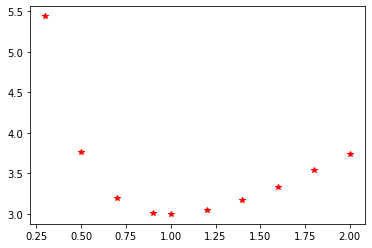

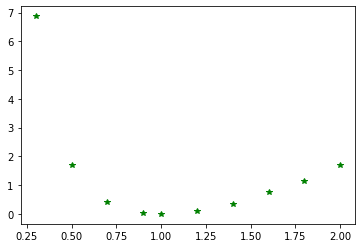

In [21]:
alpha = [0.3,0.5,0.7,0.9,1,1.2,1.4,1.6,1.8,2.0]
fig, ax = plt.subplots()
fig0, ax0 = plt.subplots()
for alphaTemp in alpha:
    Energy, Counter, Variance = MonteCarlo(100000,1,alphaTemp,3.8)
    print(Counter,Variance)
    ax.plot(alphaTemp,Energy,'r*')
    ax0.plot(alphaTemp,Variance,'g*')

**Device a way to find the optimal step length for each alpha so that acceptance rate is around 50%**

**Algorithm that takes care of finding the step size such that 50 \% acceptance rate in a brute force way:**

In [24]:
def FindStepsize(stepsize,alpha):
    MCCycles = 10000
    M = len(alpha)
    StepSize = np.zeros(M)
    counter = 0
    for i in alpha:
        StepTemp = []
        for l in stepsize:
            Energy, Counter, Variance = MonteCarlo(10000,1,i,l)
            if (Counter >= 4900) and (Counter <= 5100):
                StepTemp.append(l)
        StepSize[counter] = np.median(StepTemp)
        counter += 1
        
    return StepSize

In [27]:
#Trial
stepsize = np.arange(0,10,0.05)
alpha = np.arange(0.2,2,0.2)
print(alpha)
StepSize = FindStepsize(stepsize,alpha)

[0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8]


In [28]:
print(StepSize)

[9.275 6.55  5.35  4.65  4.175 3.8   3.525 3.275 3.1  ]


500973.6666666667
501185.5
501444.8333333333
499937.0
498667.0
499560.5
498734.3333333333
501365.5
500609.1666666667


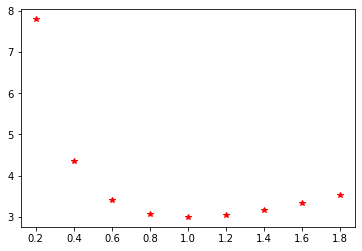

In [30]:
fig3, ax3 = plt.subplots()
for i in range(len(alpha)):
    stepTemp = StepSize[i]
    alphaTemp = alpha[i]
    Energy, Counter, Variance = MonteCarlo(1000000,1,alphaTemp,stepTemp)
    print(Counter)
    ax3.plot(alphaTemp,Energy,'r*')

# 5.c)

**First withhout Coulomb interaction:**

499003.6666666667 7.808273769298527 17.30281358301375
500850.1666666667 6.3743725062164005 10.546490184884497
498738.1666666667 5.454235946363128 6.891218626121301
499033.1666666667 4.807042411954534 4.713471991573453
502695.1666666667 4.349285505398034 3.306954137387166
500001.5 4.009627168945303 2.3700699462089254
497457.8333333333 3.748868776324519 1.6911840111990983
499067.8333333333 3.5533093004490053 1.2094331600415877
501773.8333333333 3.400486864384481 0.8544809738285792
498737.0 3.2803623215217126 0.5883744581380945
499810.1666666667 3.1948408479406862 0.3980819055863325
500148.0 3.125737871082341 0.2563621833028993
497655.8333333333 3.07385563789037 0.15143500049932435
500766.8333333333 3.040080455555834 0.07997793861683178
498478.1666666667 3.0163254433959263 0.033414126948146716
495188.6666666667 3.0040147354676363 0.007897449238566168
501012.3333333333 3.0 0.0
503093.1666666667 3.0037044500634242 0.007128248534591819
496846.3333333333 3.013420307074274 0.027462068161414166

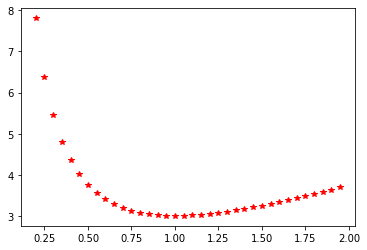

In [71]:
#Monte Carlo calculations for the first trial wave function for more number of different alpha
#first finding the optimal step size for each value of alpha
alpha1 = np.arange(0.2,2,0.05)
stepsize1 = np.arange(0,10,0.05)
StepSize1 = FindStepsize(stepsize1,alpha1)
#Then doing calculation for each alpha
fig4, ax4 = plt.subplots()
start = time.time()
for i in range(len(alpha1)):
    stepTemp = StepSize1[i]
    alphaTemp = alpha1[i]
    Energy, Counter, Variance = MonteCarlo(1000000,1,alphaTemp,stepTemp)
    print(Counter,Energy,Variance)
    ax4.plot(alphaTemp,Energy,'r*')
end = time.time()
print("Measurement took in seconds:",end-start)

**Then with Coulomb interaction:**

**First with $\omega = 1$:**

498994 8.14938796306527 16.38454928724353
501015 6.776322034481875 9.851242254977436
498721 5.887704398914798 6.3463922681062215
498741 5.282755608840074 4.2418043578210884
502651 4.857023424854552 2.927442807821105
500020 4.54536552841516 2.0564291965573034
497209 4.31382957259592 1.443800003514724
498968 4.144374066083318 1.0294568536668542
501525 4.016037421083851 0.7273714865169509
498699 3.9252505125750745 0.5467156464526699
499628 3.8601161358686564 0.4070034421895965
500216 3.8153691716838716 0.3154018826980156
498072 3.7879795599832966 0.2744008073452928
500843 3.773467668481155 0.26146300847673487
498824 3.7740502708288 0.2914798294264731
495470 3.7813953689964097 0.3207058297024403
500927 3.7981620003966357 0.3652002754695758
502973 3.8210163868042843 0.42609835326579315
496852 3.8513590552844126 0.5054657230051838
500596 3.884951446126634 0.6359578532504973
499787 3.925249130938374 0.6879267588545943
496987 3.9667142922982426 0.8161738124451965
500101 4.013247826426076 0.929

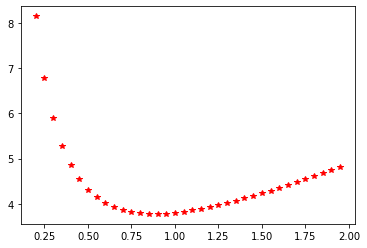

In [86]:
fig5, ax5 = plt.subplots()
omega = 1
EnergyTotal = np.zeros(len(alpha1))
CounterTotal = np.zeros(len(alpha1))
VarianceTotal = np.zeros(len(alpha1))
ElectronDistanceTotal = np.zeros(len(alpha1))
start = time.time()
for i in range(len(alpha1)):
    stepTemp = StepSize1[i]
    alphaTemp = alpha1[i]
    Energy, Counter, Variance, ElectronDistance = MonteCarloCoulomb(1000000,omega,alphaTemp,stepTemp)
    EnergyTotal[i] = Energy
    CounterTotal[i] = Counter
    VarianceTotal[i] = Variance
    ElectronDistanceTotal[i] = ElectronDistance
    print(Counter, Energy,Variance)
    ax5.plot(alphaTemp,Energy,'r*')
end = time.time()
print("measurement took in seconds:",end-start)

In [90]:
#Finding the lowest energy
MinimalEnergy = np.min(EnergyTotal)
print(MinimalEnergy)
alhpaMinimal = alpha1[np.where(EnergyTotal == MinimalEnergy)[0][0]]
electronDistMinimalEnergy = ElectronDistanceTotal[np.where(EnergyTotal == MinimalEnergy)[0][0]]
print(alhpaMinimal,electronDistMinimalEnergy)

3.773467668481155
0.8499999999999999 1.7334738628587012


**Plotting:**

Text(0.5, 0, '$\\alpha$')

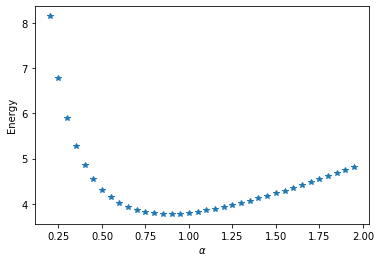

In [100]:
#Energy as a function of variational paramater alpha
fig5_1,ax5_1 = plt.subplots()
ax5_1.plot(alpha1,EnergyTotal,'*')
ax5_1.set_ylabel("Energy")
ax5_1.set_xlabel(r"$\alpha$")

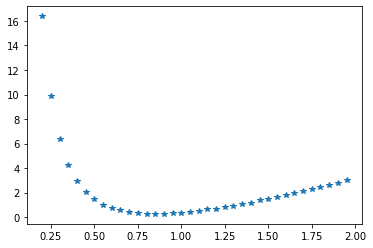

In [98]:
#Variance as a function of variational parameter alpha
fig5_2,ax5_2 = plt.subplots()
ax5_2.plot(alpha1,VarianceTotal,'*')

**Then with $\omega = 0.01$:**

941236 0.11424873371885315 0.0016163925543017273
941358 0.10379946253129864 0.0012055980948031553
941010 0.09835522205888969 0.0010926655664615804
941287 0.0952538627855975 0.0011094474565708085
942063 0.0942639070352896 0.0013086273488339215
941553 0.09368967435449617 0.0014334753464336613
941073 0.09420305548732101 0.0015652316617328962
941452 0.0946986555753876 0.0017023824485125991
941513 0.09570562362603491 0.0018495543763275314
941119 0.09730221259343826 0.0021269744724796633
941320 0.09830992878974006 0.0022968258014759713
941631 0.1005200937853109 0.0026314340633538016
941000 0.10182330910457542 0.0026310544539783227
941752 0.10375302906984157 0.002907223011980948
941302 0.10594100025294916 0.0031785269334863135
940578 0.10742840184116263 0.0034258836978197198
941798 0.11039842294019724 0.0038253341847446377
941721 0.11107918711449903 0.003744161843273636
940856 0.11334001634126123 0.0040084902240391535
941597 0.11642084829246858 0.004361534766765922
941311 0.1178204170192082 0

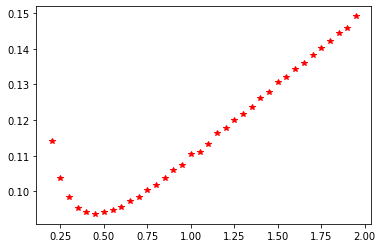

In [92]:
fig6, ax6 = plt.subplots()
omega = 0.01
EnergyTotal1 = np.zeros(len(alpha1))
CounterTotal1= np.zeros(len(alpha1))
VarianceTotal1 = np.zeros(len(alpha1))
ElectronDistanceTotal1 = np.zeros(len(alpha1))
start = time.time()
for i in range(len(alpha1)):
    stepTemp = StepSize1[i]
    alphaTemp = alpha1[i]
    Energy, Counter, Variance, ElectronDistance = MonteCarloCoulomb(1000000,omega,alphaTemp,stepTemp)
    EnergyTotal1[i] = Energy
    CounterTotal1[i] = Counter
    VarianceTotal1[i] = Variance
    ElectronDistanceTotal1[i] = ElectronDistance
    print(Counter, Energy,Variance)
    ax6.plot(alphaTemp,Energy,'r*')
end = time.time()
print("measurement took in seconds:",end-start)

In [93]:
#Finding the lowest energy
MinimalEnergy1 = np.min(EnergyTotal1)
print(MinimalEnergy1)
alhpaMinimal1 = alpha1[np.where(EnergyTotal1 == MinimalEnergy1)[0][0]]
electronDistMinimalEnergy1 = ElectronDistanceTotal1[np.where(EnergyTotal1 == MinimalEnergy1)[0][0]]
print(alhpaMinimal1,electronDistMinimalEnergy1)

0.09368967435449617
0.44999999999999996 23.61962129279101


**Then with $\omega = 0.5$:**

617775 4.15144726928392 4.05748941523774
619521 3.468623118320059 2.4203605452105723
617641 3.034424526505175 1.5454170910983134
617905 2.7428291235204774 1.0359268757964566
621313 2.5292047964269946 0.7157565529884238
618970 2.3816407729053823 0.5006014891990898
616794 2.2743817708178278 0.3626091985660036
617869 2.1938193353932682 0.26749090206904214
620112 2.1369155058068685 0.20141467819332703
617811 2.0955653395260665 0.16025724544318454
618963 2.069672405103526 0.1450320549923978
619065 2.0513551315104563 0.12994990408313623
616974 2.042143867315431 0.1256099852349788
619613 2.04047920249556 0.13422995006700678
617824 2.043666167811116 0.14401037095403968
614550 2.0525620573792036 0.15704184297849544
619314 2.064262213497778 0.18194608356883624
621296 2.079373317530362 0.1971973093135171
616113 2.098514320826069 0.22427988474071459
619045 2.1201022034383517 0.2774724524355454
618543 2.1423376815280086 0.29255217977920545
616090 2.1680195678754175 0.33779974755892095
618634 2.1953

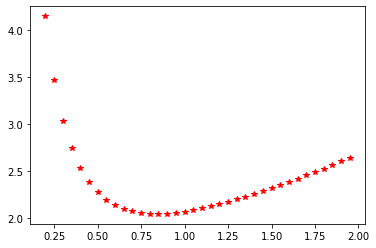

In [94]:
fig7, ax7 = plt.subplots()
omega = 0.5
EnergyTotal2 = np.zeros(len(alpha1))
CounterTotal2 = np.zeros(len(alpha1))
VarianceTotal2 = np.zeros(len(alpha1))
ElectronDistanceTotal2 = np.zeros(len(alpha1))
start = time.time()
for i in range(len(alpha1)):
    stepTemp = StepSize1[i]
    alphaTemp = alpha1[i]
    Energy, Counter, Variance, ElectronDistance = MonteCarloCoulomb(1000000,omega,alphaTemp,stepTemp)
    EnergyTotal2[i] = Energy
    CounterTotal2[i] = Counter
    VarianceTotal2[i] = Variance
    ElectronDistanceTotal2[i] = ElectronDistance
    print(Counter, Energy,Variance)
    ax7.plot(alphaTemp,Energy,'r*')
end = time.time()
print("measurement took in seconds:",end-start)

In [95]:
#Finding the lowest energy
MinimalEnergy2 = np.min(EnergyTotal2)
print(MinimalEnergy2)
alhpaMinimal2 = alpha1[np.where(EnergyTotal2 == MinimalEnergy2)[0][0]]
electronDistMinimalEnergy2 = ElectronDistanceTotal2[np.where(EnergyTotal2 == MinimalEnergy2)[0][0]]
print(alhpaMinimal2,electronDistMinimalEnergy2)

2.04047920249556
0.8499999999999999 2.448702153628894
